In [4]:
import os
import pylab
import calendar
import seaborn as sn
import missingno as msno
from datetime import datetime
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

/Users/evanliu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
dailyData = pd.read_csv("train.csv")
dailyDataTest = pd.read_csv("test.csv")
dailyData.drop(['row_id'], axis=1, inplace=True)
dailyDataTest.drop(['row_id'], axis=1, inplace=True)

# convert negative trip_distance to positive values
for index in dailyData.index:
    if dailyData['trip_distance'][index]<0:
        dailyData['trip_distance'][index] = -dailyData['trip_distance'][index]
# convert negative trip_distance to positive values
for index in dailyDataTest.index:
    if dailyDataTest['trip_distance'][index]<0:
        dailyDataTest['trip_distance'][index] = -dailyDataTest['trip_distance'][index]

# remove all data with trip_distance=0
dailyData = dailyData.query('trip_distance > 0.1')
# top speed for taxi 36s/mile
dailyData = dailyData.query('duration >= trip_distance*36')
# speed on foot 1200s/mile
dailyData1 = dailyData.query('duration <= trip_distance*1200')
# include some severe traffic jam and short trip distance
dailyData2 = dailyData.query('duration > trip_distance*1200 and trip_distance < 10 and duration < 7200')
dailyData = dailyData1.append(dailyData2)
dailyData.reset_index(inplace=True)
dailyData.drop('index',inplace=True,axis=1)
#remove outliers
# dailyData = dailyData.query('duration < 10000')

dailyData['duration']=np.log1p(dailyData['duration'])
y = dailyData['duration'].reset_index(drop=True) 
train_features = dailyData.drop(['duration'],axis=1)
test_features = dailyDataTest
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print("剔除训练数据中的极端值后，将其特征矩阵和测试数据中的特征矩阵合并，维度为:",features.shape)

剔除训练数据中的极端值后，将其特征矩阵和测试数据中的特征矩阵合并，维度为: (355471, 8)


In [40]:
features.dtypes

VendorID           float64
pickup_datetime     object
passenger_count    float64
trip_distance      float64
pickup_borough      object
pickup_zone         object
dropoff_borough     object
dropoff_zone        object
dtype: object

In [42]:
# fill nan with 2019-03-31 00:00:00 in datetime
dailyData = dailyData.rename(columns={'pickup_datetime':'datetime'})
dailyData['datetime'].fillna("2019-03-31 00:00:00",inplace=True)
dailyData[["datetime"]] = dailyData[["datetime"]].astype(str)
dailyData['hour'] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.datetime.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString.split()[0],"%Y-%m-%d").weekday()])

# calculate the duration mean of hour-weekday pair
hour_weekday_mean = dailyData.groupby(["hour","weekday"],sort=True)["duration"].mean()

# calculate duration mean in terms of hour
hour_mean = dailyData.groupby("hour").mean()['duration']

# fill nan with 2019-03-31 00:00:00 in datetime
features = features.rename(columns={'pickup_datetime':'datetime'})
features['datetime'].fillna("2019-03-31 00:00:00",inplace=True)
features[["datetime"]] = features[["datetime"]].astype(str)

# Remove the nan from dropoff_zone and pickup_zone
features['dropoff_zone'].fillna("NV",inplace=True)
features['pickup_zone'].fillna("NV",inplace=True)

# Fill nan with specific number
features['passenger_count'].fillna(1,inplace=True)
features['VendorID'].fillna(2,inplace=True)

# get weekday
features['year'] = features.datetime.apply(lambda x : x.split()[0].split("-")[0])
features['month'] = features.datetime.apply(lambda x : x.split()[0].split("-")[1])
features['day'] = features.datetime.apply(lambda x : x.split()[0].split("-")[2])
features['hour'] = features.datetime.apply(lambda x : x.split()[1].split(":")[0])
features["weekday"] = features.datetime.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString.split()[0],"%Y-%m-%d").weekday()])

# combine pickup_zone & dropoff_zone, hour & weekkday
# features['zone'] = features.apply(lambda x: str(x['pickup_zone'])+"-"+str(x['dropoff_zone']),axis=1)
features['hour_weekday'] = features.apply(lambda x: str(x['hour'])+"-"+str(x['weekday']),axis=1)
features['borough_path'] = features.apply(lambda x: str(x['pickup_borough'])+"-"+str(x['dropoff_borough']),axis=1)

# calculate the duration mean of hour-weekday pair
weekday_order = {"Friday":0,"Monday":1,"Saturday":2,"Sunday":3,"Thursday":4,"Tuesday":5,"Wednesday":6}
features['hour_weekday_mean'] = features.apply(lambda x: hour_weekday_mean[7*int(x["hour"])+weekday_order[x["weekday"]]],axis=1)

# calculate duration mean in terms of hour
features['hour_mean'] = features.apply(lambda x: hour_mean[int(x['hour'])],axis=1)

# calculate log1p(trip_distance)
features['trip_distance_log'] = features.apply(lambda x: np.log1p(x['trip_distance']),axis=1)

# workday or not
features['workday'] = features.apply(lambda x: 1 if x['weekday'] in ["Monday","Tuesday","Wednesday","Thursday","Friday"] else 0,axis=1)
features['same_borough'] = features.apply(lambda x: 1 if x['pickup_borough']==x['dropoff_borough']  else 0,axis=1)
# features = features.drop(["year","hour_weekday","day","datetime","passenger_count","dropoff_zone","pickup_zone","VendorID",], axis=1)

# categoricalFeatureNames = ["workday","month","hour","weekday","pickup_borough","dropoff_borough"]
# for var in categoricalFeatureNames:
#     features[var] = features[var].astype("category")

In [45]:
features.dtypes

VendorID               int64
passenger_count        int64
trip_distance        float64
pickup_borough        object
pickup_zone           object
dropoff_borough       object
dropoff_zone          object
year                  object
month                 object
hour                  object
weekday               object
hour_weekday          object
borough_path          object
hour_weekday_mean    float64
hour_mean            float64
trip_distance_log    float64
workday                int64
same_borough           int64
dtype: object

In [44]:
features = features.drop(["day","datetime",], axis=1)
features.VendorID = features.VendorID.astype(int)
features.passenger_count = features.passenger_count.astype(int)

In [47]:
features.dtypes

VendorID                 int64
passenger_count          int64
trip_distance          float64
hour_weekday_mean      float64
hour_mean              float64
trip_distance_log      float64
workday                  int64
same_borough             int64
pickup_borough_int       int64
pickup_zone_int          int64
dropoff_borough_int      int64
dropoff_zone_int         int64
year_int                 int64
month_int                int64
hour_int                 int64
weekday_int              int64
hour_weekday_int         int64
borough_path_int         int64
dtype: object

In [48]:
######################数字型数据列偏度校正-【开始】#######################
#使用skew()方法，计算所有整型和浮点型数据列中，数据分布的偏度（skewness）。
#偏度是统计数据分布偏斜方向和程度的度量，是统计数据分布非对称程度的数字特征。亦称偏态、偏态系数。
numeric_dtypes = ['float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

#以0.5作为基准，统计偏度超过此数值的高偏度分布数据列，获取这些数据列的index。
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

#对高偏度数据进行处理，将其转化为正态分布。
#Box和Cox提出的变换可以使线性回归模型满足线性性、独立性、方差齐次以及正态性的同时，又不丢失信息。
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))#这是boxcox1p的使用方法，参数的具体意义暂时不解释
######################数字型数据列偏度校正-【结束】#######################

In [51]:
X = features.iloc[:len(y), :]	#y是列向量，存储了训练数据中的房价列信息。截取后得到的X阵的维度是len(y)*(final_features的列数)。
X_sub = features.iloc[len(y):, :]#使用len命令，求矩阵X的长度，得到的是矩阵对象的长度，即有矩阵中有多少列，而不是每列上有多少行。
outliers = [273591, 274024, 275423, 79323, 237758]
X = X.drop(X.index[outliers])#因为X阵是经过对特征矩阵进行类似“坐标投影”操作后得到的，列向量y中的行号对应着X阵中的列号。
y = y.drop(y.index[outliers])

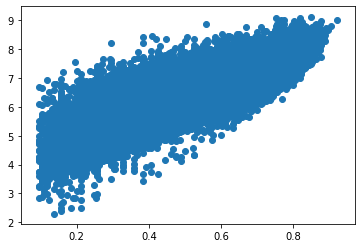

In [52]:
plt.scatter(X.trip_distance_log,y)

In [53]:
overfit = []#用来记录产生过拟合的数据列的序号
for i in X.columns:#遍历截取后特征矩阵的每一列
    counts = X[i].value_counts()#使用.value_counts()方法，查看在X矩阵的第i列中，不同的取值分别出现了多少次，默认按次数最高到最低做降序排列。返回一个df。
    zeros = counts.iloc[0]#通过行号索引行数据，取出counts列中第一个元素，即出现次数最多的取值到底是出现了多少次，存入zeros
    if zeros / len(X) * 100 > 99.94:
#判断某一列是否将产生过拟合的条件：
#截取后的特征矩阵有len(X)列，如果某一列中的某个值出现的次数除以特征矩阵的列数超过99.94%，即其几乎在被投影的各个维度上都有着同样的取值，并不具有“主成分”的性质，则记为过拟合列。
        overfit.append(i)
overfit = list(overfit)
#overfit.append('MSZoning_C (all)')#这条语句有用吗？是要把训练数据特征矩阵X中的列标签为'MSZoning_C (all)'的列也删除吗？但是训练数据中并没有任何一个列标签名称为MSZoning_C (all)。
X = X.drop(overfit, axis=1)#.copy()#删除截取后特征矩阵X中的过拟合列。因为drop并不影响原数据，所以使用copy。直接覆值应该也可以。
X_sub = X_sub.drop(overfit, axis=1)#.copy()

In [54]:
X.shape

(276065, 18)

In [55]:
X_sub.shape

(79393, 18)

In [56]:
##############################################################机器学习-【开始】###################################################################################
print('特征处理已经完成。开始对训练数据进行机器学习', datetime.now())

#设置k折交叉验证的参数。
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)


#定义均方根对数误差（Root Mean Squared Logarithmic Error ，RMSLE）
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


#创建模型评分函数，根据不同模型的表现打分
#cv表示Cross-validation,交叉验证的意思。
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

特征处理已经完成。开始对训练数据进行机器学习 2020-05-03 01:19:56.878033


In [57]:
#############个体机器学习模型的创建（即模型声明和参数设置）-【开始】############
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

#定义ridge岭回归模型（使用二范数作为正则化项。不论是使用一范数还是二范数，正则化项的引入均是为了降低过拟合风险。）
#注：正则化项如果使用二范数，那么对于任何需要寻优的参数值，在寻优终止时，它都无法将某些参数值变为严格的0，尽管某些参数估计值变得非常小以至于可以忽略。即使用二范数会保留变量的所有信息，不会进行类似PCA的变量凸显。
#注：正则化项如果使用一范数，它比L2范数更易于获得“稀疏(sparse)”解，即它的求解结果会有更多的零分量。
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

#定义LASSO收缩模型（使用L1范数作为正则化项）（由于对目标函数的求解结果中将得到很多的零分量，它也被称为收缩模型。）
#注：正则化项如果使用二范数，那么对于任何需要寻优的参数值，在寻优终止时，它都无法将某些参数值变为严格的0，尽管某些参数估计值变得非常小以至于可以忽略。即使用二范数会保留变量的所有信息，不会进行类似PCA的变量凸显。
#注：正则化项如果使用一范数，它比L2范数更易于获得“稀疏(sparse)”解，即它的求解结果会有更多的零分量。										
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))

#定义elastic net弹性网络模型（弹性网络实际上是结合了岭回归和lasso的特点，同时使用了L1和L2作为正则化项。）									
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

#定义GB梯度提升模型（展开到一阶导数）									
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

#定义lightgbm模型									
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )

#定义xgboost模型（展开到二阶导数）                                      
# xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)
#############个体机器学习模型的创建（即模型声明和参数设置）-【结束】############

In [11]:
###########################集成多个个体学习器-【开始】##########################
###！！！！！！！！！！！！
###！！！！！！！！！！！！
###！！！！！！！！！！！！
###！！！！！！！！！！！！
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)#regressors=(...)中并没有纳入前面的svr模型
###########################集成多个个体学习器-【结束】##########################                             

############################进行交叉验证打分-【开始】###########################
#进行交叉验证，并对不同模型的表现打分
#（由于是交叉验证，将使用不同的数据集对同一模型进行评分，故每个模型对应一个得分序列。展示模型得分序列的平均分、标准差）
print('进行交叉验证，计算不同模型的得分TEST score on CV')

#打印二范数rideg岭回归模型的得分
score = cv_rmse(ridge)
print("二范数rideg岭回归模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印一范数LASSO收缩模型的得分
score = cv_rmse(lasso)
print("一范数LASSO收缩模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印elastic net弹性网络模型的得分
score = cv_rmse(elasticnet)
print("elastic net弹性网络模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# #打印SVR支持向量机模型的得分
# score = cv_rmse(svr)
# print("SVR支持向量机模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印lightgbm轻梯度提升模型的得分
score = cv_rmse(lightgbm)
print("lightgbm轻梯度提升模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印gbr梯度提升回归模型的得分
score = cv_rmse(gbr)
print("gbr梯度提升回归模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印xgboost模型的得分
score = cv_rmse(xgboost)
print("xgboost模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
############################进行交叉验证打分-【结束】###########################

进行交叉验证，计算不同模型的得分TEST score on CV
lightgbm轻梯度提升模型的得分: 0.3190 (0.0012)
 2020-05-02 10:22:24.299037
gbr梯度提升回归模型的得分: 0.3014 (0.0011)
 2020-05-02 11:11:51.337355
[11:11:53] WARNING: /private/var/folders/ps/ksq1f2ys3yb_lz7s32c1g8280000gn/T/pip-install-zp3recm6/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:55] WARNING: /private/var/folders/ps/ksq1f2ys3yb_lz7s32c1g8280000gn/T/pip-install-zp3recm6/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:27] WARNING: /private/var/folders/ps/ksq1f2ys3yb_lz7s32c1g8280000gn/T/pip-install-zp3recm6/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:02] WARNING: /private/var/folders/ps/ksq1f2ys3yb_lz7s32c1g8280000gn/T/pip-install-zp3recm6/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15

进行交叉验证，计算不同模型的得分TEST score on CV<br>
二范数rideg岭回归模型的得分: 0.3205 (0.0012)<br>
 2020-05-02 00:15:30.857070<br>
一范数LASSO收缩模型的得分: 0.3208 (0.0012)<br>
 2020-05-02 01:33:14.781908<br>
elastic net弹性网络模型的得分: 0.3212 (0.0012)<br>
 2020-05-02 02:23:17.939383<br>

In [12]:
#########使用训练数据特征矩阵作为输入，训练数据对数处理后的预测房价作为输出，进行各个模型的训练-【开始】#########
#开始集合所有模型，使用stacking方法
print('进行模型参数训练 START Fit')

print(datetime.now(), '对stack_gen集成器模型进行参数训练')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print(datetime.now(), '对elasticnet弹性网络模型进行参数训练')
elastic_model_full_data = elasticnet.fit(X, y)

print(datetime.now(), '对一范数lasso收缩模型进行参数训练')
lasso_model_full_data = lasso.fit(X, y)

print(datetime.now(), '对二范数ridge岭回归模型进行参数训练')
ridge_model_full_data = ridge.fit(X, y)

print(datetime.now(), '对lightgbm轻梯度提升模型进行参数训练')
lgb_model_full_data = lightgbm.fit(X, y)

print(datetime.now(), '对GradientBoosting梯度提升模型进行参数训练')
gbr_model_full_data = gbr.fit(X, y)

print(datetime.now(), '对xgboost二阶梯度提升模型进行参数训练')
xgb_model_full_data = xgboost.fit(X, y)


#########使用训练数据特征矩阵作为输入，训练数据对数处理后的预测房价作为输出，进行各个模型的训练-【结束】#########

############################进行交叉验证打分-【结束】###########################

进行模型参数训练 START Fit
2020-05-02 17:18:43.563359 对stack_gen集成器模型进行参数训练
[21:28:23] WARNING: /private/var/folders/ps/ksq1f2ys3yb_lz7s32c1g8280000gn/T/pip-install-zp3recm6/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[22:37:46] WARNING: /private/var/folders/ps/ksq1f2ys3yb_lz7s32c1g8280000gn/T/pip-install-zp3recm6/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:41] WARNING: /private/var/folders/ps/ksq1f2ys3yb_lz7s32c1g8280000gn/T/pip-install-zp3recm6/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

In [ ]:
########定义个体学习器的预测值融合函数，检测预测值融合策略的效果-【开始】#######
#综合多个模型产生的预测值，作为多模型组合学习器的预测值
def blend_models_predict(X):
    return ((0.05 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

#打印在上述模型配比下，多模型组合学习器的均方根对数误差（Root Mean Squared Logarithmic Error ，RMSLE）
#使用训练数据对创造的模型进行k折交叉验证，以训练创造出的模型的参数配置。交叉验证训练过程结束后，将得到模型的参数配置。使用得出的参数配置下，在全体训练数据上进行验证，验证模型对全体训练数据重构的误差。
print('融合后的训练模型对原数据重构时的均方根对数误差RMSLE score on train data:')
########定义个体学习器的预测值融合函数，检测预测值融合策略的效果-【结束】#######

########将测试集的特征矩阵作为输入，传入训练好的模型，得出的输出写入.csv文件的第2列-【开始】########
submission = pd.read_csv("submission.csv")
#函数注释：.iloc[:,1]是基于索引位来选取数据集，[索引1:索引2]，左闭右开。
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))
########将测试集的特征矩阵作为输入，传入训练好的模型，得出的输出写入.csv文件的第2列-【结束】########
q1 = submission['duration'].quantile(0.005)
q2 = submission['duration'].quantile(0.995)
submission['duration'] = submission['duration'].apply(lambda x: x if x > q1 else x*0.77)
submission['duration'] = submission['duration'].apply(lambda x: x if x < q2 else x*1.1)
submission.duration=submission.duration.astype(int)
submission.head(2)
